## Importing the relevant libraries

In [4]:
#pip install wget

In [3]:
#pip install keras-tuner

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, wget
warnings.filterwarnings('ignore')
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
import tensorflow as tf
import keras_tuner as kt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from tqdm.notebook import tqdm
tqdm.pandas()
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits

100% [..............................................................................] 13881 / 13881

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\innovation_lab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
plt.rcParams['figure.figsize'] = (12,8) # Setting the default figure size

## Loading the dataset

In [6]:
df= pd.read_csv("./data/emotion-labels-all_4.csv")
#df.head()

,Unnamed: 0,text,label,clean_words,clean_list_words
0,0,Just got back from seeing @GaryDelaney in Burs...,joy,got back seeing garydelaney burslem amazing fa...,"['got', 'back', 'see', 'garydelaney', 'burslem..."
1,1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear evening absolute hilarity think laughe...,"['oh', 'dear', 'even', 'absolut', 'hilar', 'th..."
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,waiting week game ❤️❤️❤️ cheer friday ❤️,"['wait', 'week', 'game', 'cheer', 'friday']"
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardiner love thank much gloria sweet thoughtf...,"['gardin', 'love', 'thank', 'much', 'gloria', ..."
4,4,I feel so blessed to work with the family that...,joy,feel blessed work family nanny ❤️ nothing love...,"['feel', 'bless', 'work', 'famili', 'nanni', '..."


In [7]:
df = all_df.drop(all_df.columns[[0]], axis=1)  # df.columns is zero-based pd.Index
#df.head()

,Unnamed: 0,text,label,clean_words,clean_list_words
0,0,Just got back from seeing @GaryDelaney in Burs...,joy,got back seeing garydelaney burslem amazing fa...,"['got', 'back', 'see', 'garydelaney', 'burslem..."
1,1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear evening absolute hilarity think laughe...,"['oh', 'dear', 'even', 'absolut', 'hilar', 'th..."
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,waiting week game ❤️❤️❤️ cheer friday ❤️,"['wait', 'week', 'game', 'cheer', 'friday']"
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardiner love thank much gloria sweet thoughtf...,"['gardin', 'love', 'thank', 'much', 'gloria', ..."
4,4,I feel so blessed to work with the family that...,joy,feel blessed work family nanny ❤️ nothing love...,"['feel', 'bless', 'work', 'famili', 'nanni', '..."


## Data Exploration, Exploratory Data Analysis (EDA) and Feature Engineering

In [8]:
#df.shape

(7102, 5)

In [9]:
#df.label.value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: label, dtype: int64

In [10]:
#df.isnull().sum()

Unnamed: 0          0
text                0
label               0
clean_words         0
clean_list_words    0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
df.drop_duplicates(subset=['text'], inplace=True)
print(df.shape)

(6908, 5)


In [13]:
## Checking for any empty strings within the text column
#df.text.str.isspace().sum()

0

In [14]:
df['text_len'] = df.text.apply(len)
#df.head()

,Unnamed: 0,text,label,clean_words,clean_list_words,text_len
0,0,Just got back from seeing @GaryDelaney in Burs...,joy,got back seeing garydelaney burslem amazing fa...,"['got', 'back', 'see', 'garydelaney', 'burslem...",110
1,1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear evening absolute hilarity think laughe...,"['oh', 'dear', 'even', 'absolut', 'hilar', 'th...",94
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,waiting week game ❤️❤️❤️ cheer friday ❤️,"['wait', 'week', 'game', 'cheer', 'friday']",60
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardiner love thank much gloria sweet thoughtf...,"['gardin', 'love', 'thank', 'much', 'gloria', ...",129
4,4,I feel so blessed to work with the family that...,joy,feel blessed work family nanny ❤️ nothing love...,"['feel', 'bless', 'work', 'famili', 'nanni', '...",114


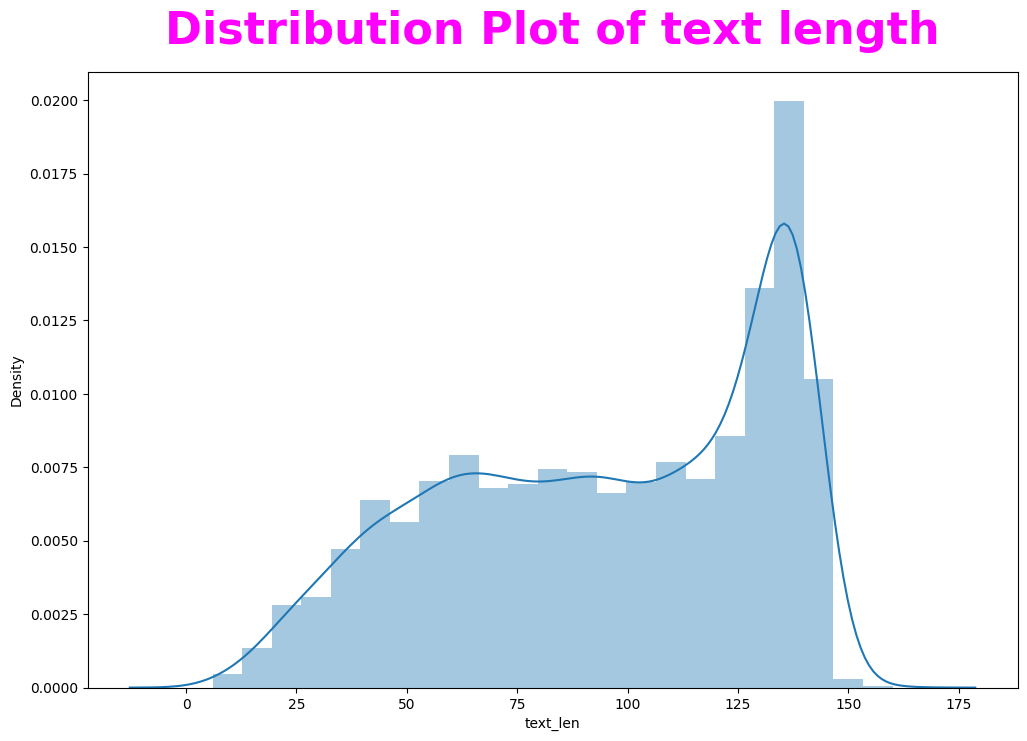

In [15]:
#sns.distplot(df.text_len)
#plt.title('Distribution Plot of text length',fontsize=32,color='magenta',fontweight='bold',pad=20);

In [16]:
#df.describe()

,Unnamed: 0,text_len
count,6908.000000,6908.000000
mean,3501.766503,95.155327
std,2044.121198,36.581244
min,0.000000,6.000000
25%,1727.750000,65.000000
50%,3497.500000,100.000000
75%,5261.250000,131.000000
max,7101.000000,160.000000


In [17]:
max_text_len = 131 # Setting the max text length to its third quantile value

## Encoding the target labels

In [18]:
labels_dict = {}

for idx, label in enumerate(df.label.unique()):
    labels_dict[label] = idx

#labels_dict

{'joy': 0, 'fear': 1, 'anger': 2, 'sadness': 3}

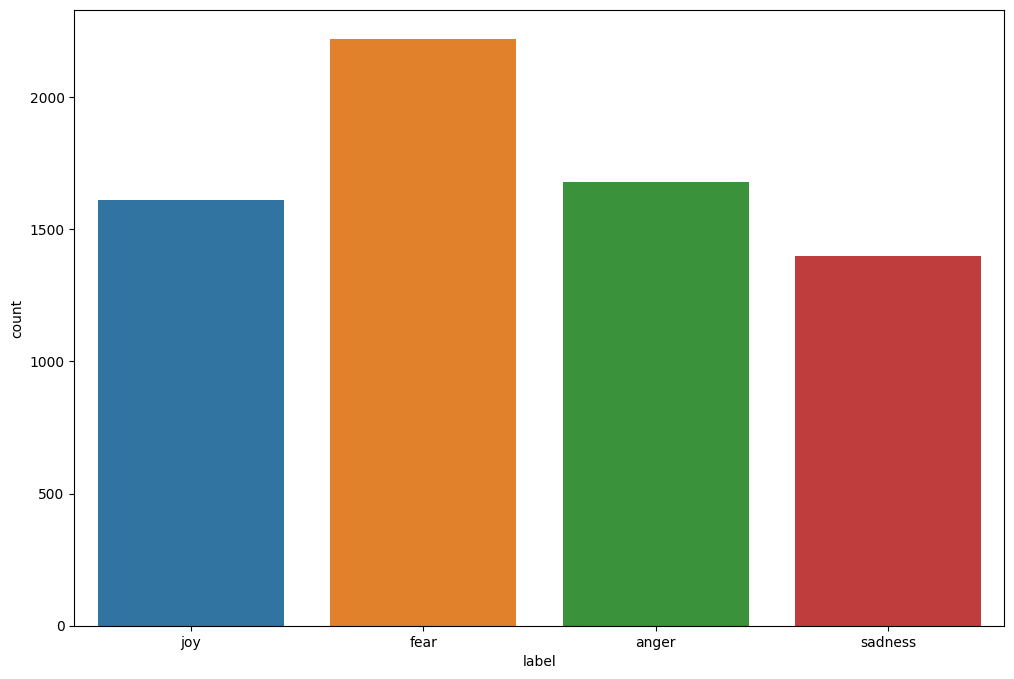

In [19]:
#sns.countplot(df,x='label');

There are 4 emotions in total, fear, sadness, joy and anger. As is evident from the above graph, the class "fear" has the highest instances, which is followed by the emotions "anger", "joy" and "sadness" with "sadness" having the least instances.

In [20]:
df.label = df.label.apply(lambda x: labels_dict[x])

## Downloading the pretrained tokenizer and BERT transformer model from the Hugging Face platform

In [21]:
tokenizer = AutoTokenizer.from_pretrained('LawalAfeez/emotion_detection')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('LawalAfeez/emotion_detection')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at LawalAfeez/emotion_detection.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprecessed dataset into train and test sets

In [22]:
train_df, test_df = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.label)

## Performing tokenization of text data

In [23]:
X_train = tokenizer(text=train_df.clean_words.tolist(),
                   add_special_tokens=True,
                   padding="max_length",
                   truncation=False,
                   max_length=max_text_len,
                   return_tensors='tf',
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=1)

X_test = tokenizer(text=test_df.clean_words.tolist(),
                  add_special_tokens=True,
                  padding="max_length",
                  truncation=False,
                  max_length=max_text_len,
                  return_tensors='tf',
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  verbose=1)

## Defining the model architecture

In [24]:
input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')

In [25]:
word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=2048,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=4,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
#model.layers

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
# Making the pretrained BERT transformer model layer trainable so that it can be fine-tuned according to our custom dataset
model.layers[2].trainable = True

## Visualizing the model architecture

In [27]:
#model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 131)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 131)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                                 hidden_states=None                                           

## Compiling the model

In [28]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           weight_decay=1e-2,
           clipnorm=1.0)

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics='categorical_accuracy')

## Training the fine-tuned BERT transformer model

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=150,mode='max',verbose=1,restore_best_weights=True,start_from_epoch=50)
mc = ModelCheckpoint('emotion_detector.h5',monitor='val_balanced_accuracy',verbose=1,save_best_only=True,mode='max')

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_df.label),
             epochs=50,
             batch_size=64,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
             )

Epoch 1/50
 2/76 [..............................] - ETA: 14:19 - loss: 1.8357 - categorical_accuracy: 0.2969

## Visualizing the model performance during training

In [ ]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();
plt.savefig("loss_Graph_4_sentiment")

In [ ]:
plt.plot(r.history['categorical_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_categorical_accuracy'],'b',label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical Accuracy Graph')
plt.legend();
plt.savefig("categorical_Acc_4_sentiment")

## Tuning the hyperparameters of the fine-tuned BERT transformer model

In [36]:
def build_model(hp):
    input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
    attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')
    word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
    output = Flatten()(word_embeddings)
    
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        output = Dense(units=hp.Int('units'+str(i),min_value=32,max_value=1024,step=32),
                       activation=hp.Choice("activation",["relu","tanh","sigmoid"]))(output)
        output = BatchNormalization()(output)
        # can add more drop out values !!!!!
        output = Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(output)
    # change categorical number here 
    output = Dense(units=4,activation='softmax')(output)
    model = Model(inputs=[input_ids,attention_mask],outputs=output)
    model.layers[2].trainable = True
    optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta','nadam'])
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics='categorical_accuracy')
    return model

In [37]:
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective(name='val_categorical_accuracy',direction='max'),
                        project_name='hyperparameter-tuning',
                        directory='my_dir')

In [38]:
tuner.search({'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']}, 
             to_categorical(train_df.label), 
             epochs=50,
             batch_size=64,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, to_categorical(test_df.label)))

Trial 10 Complete [00h 41m 40s]
val_categorical_accuracy: 0.3172219693660736

Best val_categorical_accuracy So Far: 0.8629751205444336
Total elapsed time: 07h 02m 01s


In [39]:
tuner.get_best_hyperparameters()[0].values # Displaying the most optimal hyperparameters

{'num_layers': 6,
 'units0': 640,
 'activation': 'relu',
 'dropout0': 0.3,
 'optimizer': 'sgd',
 'units1': 32,
 'dropout1': 0.1,
 'units2': 32,
 'dropout2': 0.1,
 'units3': 32,
 'dropout3': 0.1,
 'units4': 32,
 'dropout4': 0.1,
 'units5': 32,
 'dropout5': 0.1}

In [40]:
try:
    final_model = tuner.get_best_models(num_models=1)[0] # Fetching the best performing model
    print(final_model)
except Exception as e:
    print(e)

## Evaluating the performance of the fine-tuned DistilBERT transformer model on test data

### Baseline fine-tuned DistilBERT model evaluation

In [41]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Sparse Categorical Balanced Crossentropy Loss:",loss)
print("Test Balanced Categorical Accuracy:",acc)

67/67 [==============================] - 8s 100ms/step - loss: 1.1093 - categorical_accuracy: 0.8592
Test Sparse Categorical Balanced Crossentropy Loss: 1.1093335151672363
Test Balanced Categorical Accuracy: 0.8592210412025452


In [42]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

67/67 [==============================] - 9s 97ms/step
Dictionary of encoded labels: {'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       676
           1       0.85      0.81      0.83       460
           2       0.92      0.89      0.90       485
           3       0.90      0.82      0.86       510

    accuracy                           0.86      2131
   macro avg       0.87      0.86      0.86      2131
weighted avg       0.86      0.86      0.86      2131



In [43]:
print("Accuracy Score:",accuracy_score(test_df.label,test_predictions))
print("Micro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='macro'))
print("Weighted Precision Score:",precision_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='macro'))
print("Weighted Recall Score:",recall_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='macro'))
print("Weighted F1 Score:",f1_score(test_df.label,test_predictions,average='weighted'))

Accuracy Score: 0.8592210229938996
Micro-Averaged Precision Score: 0.8592210229938996
Macro-Averaged Precision Score: 0.8679396176468916
Weighted Precision Score: 0.8625664847936705
Micro-Averaged Recall Score: 0.8592210229938996
Macro-Averaged Recall Score: 0.8554711326736939
Weighted Recall Score: 0.8592210229938996
Micro-Averaged F1 Score: 0.8592210229938996
Macro-Averaged F1 Score: 0.8604079281821589
Weighted F1 Score: 0.8594579169032848


### Model evaluation after tuning the hyperparameters of fine-tuned DistilBERT model

In [44]:
loss, acc = final_model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Sparse Categorical Balanced Crossentropy Loss:",loss)
print("Test Balanced Categorical Accuracy:",acc)

67/67 [==============================] - 11s 103ms/step - loss: 1.0297 - categorical_accuracy: 0.8630
Test Sparse Categorical Balanced Crossentropy Loss: 1.0297473669052124
Test Balanced Categorical Accuracy: 0.8629751205444336


In [45]:
test_predictions = final_model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

67/67 [==============================] - 9s 98ms/step
Dictionary of encoded labels: {'fear': 0, 'sadness': 1, 'joy': 2, 'anger': 3}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       676
           1       0.86      0.81      0.83       460
           2       0.93      0.88      0.91       485
           3       0.89      0.83      0.86       510

    accuracy                           0.86      2131
   macro avg       0.87      0.86      0.86      2131
weighted avg       0.87      0.86      0.86      2131



In [46]:
print("Accuracy Score:",accuracy_score(test_df.label,test_predictions))
print("Micro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='macro'))
print("Weighted Precision Score:",precision_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='macro'))
print("Weighted Recall Score:",recall_score(test_df.label,test_predictions,average='weighted'))
print("Micro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='micro'))
print("Macro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='macro'))
print("Weighted F1 Score:",f1_score(test_df.label,test_predictions,average='weighted'))

Accuracy Score: 0.8629751290473956
Micro-Averaged Precision Score: 0.8629751290473956
Macro-Averaged Precision Score: 0.8722899934191831
Weighted Precision Score: 0.8666208703178802
Micro-Averaged Recall Score: 0.8629751290473956
Macro-Averaged Recall Score: 0.8586897619786459
Weighted Recall Score: 0.8629751290473956
Micro-Averaged F1 Score: 0.8629751290473957
Macro-Averaged F1 Score: 0.864177036204409
Weighted F1 Score: 0.8633345834459296
